# RGQFT Multiplier

This program simulates a quantum circuit for binary multiplication using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

## 1. Introduction
The DraperQFTAdder is a quantum circuit designed for efficient addition using the Quantum Fourier Transform (QFT). This document explains the logic, structure, and step-by-step implementation of the circuit from fundamental principles to the final construction.

## 2. Draper QFT Adder
### Quantum Fourier Transform-Based Addition
The **Draper Quantum Adder** utilizes the **Quantum Fourier Transform (QFT)** to perform addition efficiently in the frequency domain. Unlike classical ripple-carry adders, which require carry propagation, the Draper adder encodes numbers into phase space and applies controlled phase shifts to achieve addition.

The process consists of the following steps:

1. **Applying QFT:** The input number is transformed from the computational basis to the frequency domain.
2. **Encoding the Second Operand:** Phase shifts corresponding to the second operand are applied to the transformed state.
3. **Applying Inverse QFT (IQFT):** The modified quantum state is converted back into the computational basis, yielding the sum.

---

### Quantum Circuit Representation
Quantum addition in the Fourier domain is achieved by applying a **series of Hadamard gates and controlled-phase rotations**. The following diagram illustrates a **4-qubit Draper QFT Adder**, where the transformation and inverse transformation encode the sum.

---

### Quantum Gates Used

#### Hadamard (`H`) Gate
- Used in the **Quantum Fourier Transform (QFT)** to create **equal superposition states**.
- Prepares each qubit for **phase encoding**.
$$
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

#### Controlled-Phase (`CP`) Gate
- Introduces a phase shift to the **target qubit** conditioned on the state of the **control qubit**.
- The rotation angles follow an **exponentially decreasing sequence**, ensuring correct Fourier representation.

$$
\text{CPhase}(\phi) =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\phi}
\end{pmatrix}
$$


#### Swap (`SWAP`) Gate
- Used after QFT to **reverse the qubit order**, ensuring proper binary representation.
- This is crucial because QFT operates in a **bit-reversed indexing scheme**.

$$
\text{SWAP = }
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
---

### Advantages of the Draper Adder
- **Efficient Addition:** Unlike ripple-carry methods, the Draper Adder does **not require sequential carry propagation**.
- **Quantum Arithmetic:** Used in **modular arithmetic**, **Shor's algorithm**, and other **quantum computational tasks**.
- **Scalability:** The number of quantum gates required is significantly **lower** than in classical reversible adders.

The Draper Quantum Adder demonstrates how **quantum phase manipulation** can replace classical logic operations, making it a **powerful tool for quantum computation**.

## 3. Code

### 3.1 Setup
Firstly, we need to import the necessary libraries for the program to work. If you already hasn't done install the requirements.txt or enviroment.yml.

In [63]:
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, RGQFTMultiplier
from qiskit.circuit.library.standard_gates import PhaseGate

After that, the program needs an input method. We can hard-code the
values like or we could let the user choose. It doesn’t matter which method we use. We just need to ensure that the input consists only of ones and zeros and that it is not too large so the simulation doesn't take too long. We set the maximum allowed bit length to 7.

In [64]:
#firstBinaryNumber = "1010"
#secondBinaryNumber = "110"

while True:
    firstBinaryNumber = input("Enter a 7-bit or less binary number: ")
    secondBinaryNumber = input("Enter another 7-bit or less binary number: ")

    if len(firstBinaryNumber) > 8 or len(secondBinaryNumber) > 8 or \
    not set(firstBinaryNumber).issubset({'0','1'}) or not set(secondBinaryNumber).issubset({'0','1'}):
        print("Please enter valid inputs. Try again.")
    else:
        break

To perform quantum multiplication, we must allocate space to store values.
First, we determine the largest input and take its size. After that we add zeros to the smaller number so the numbers have the same amount of digits. Based on that, we
define the necessary quantum and classical registers. Note that if you plan on using the predefined functions in qiskit you need to allocate maxInputLength + 1 to the register A for the functions to work properly. 

In [65]:
if len(firstBinaryNumber) < len(secondBinaryNumber):
    firstBinaryNumber, secondBinaryNumber = secondBinaryNumber, firstBinaryNumber

secondBinaryNumber = "0" * (len(firstBinaryNumber) - len(secondBinaryNumber)) + secondBinaryNumber
maxInputLength = len(firstBinaryNumber)
outputDigits = math.floor(math.log2(maxInputLength**2))+1

regA = QuantumRegister(maxInputLength, "regA")
regB = QuantumRegister(maxInputLength, "regB")
regC = QuantumRegister(math.floor(math.log2(maxInputLength**2))+1, "regC")
regD = ClassicalRegister(math.floor(math.log2(maxInputLength**2))+1, "regD")
qc = QuantumCircuit(regA, regB, regC, regD, name="qc")

#qc.draw("mpl")

- **`regA`** (Quantum Register, `maxInputLength` qubits)
  - This register stores the first binary number.
  - Each qubit represents a bit of the input, initialized in the `|0⟩` or `|1⟩` state based on the binary number.
  
- **`regB`** (Quantum Register, `maxInputLength + 1` qubits)
  - This register stores the second binary number and also serves as the output register.
  - The extra qubit (`+1`) is necessary to accommodate possible carry-over in the final sum.
  
- **`regC`** (Classical Register, `maxInputLength + 1` bits)
  - This is a classical register used to store the final measured result.
  - After running the quantum computation, the output is measured and saved into `regC`.

Right now, the registers are empty. So we need to put our data in them.
Because all of the individual qbits are set to |0⟩ as default we just need to
use the NOT gate on the qbits that we want to flip into |1⟩.

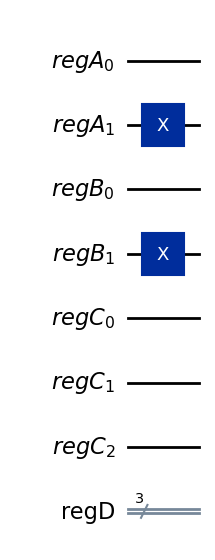

In [66]:
for idx, val in enumerate(firstBinaryNumber):
    if val == "1":
        qc.x(regA[maxInputLength - (idx + 1)])
for idx, val in enumerate(secondBinaryNumber):
    if val == "1":
        qc.x(regB[maxInputLength - (idx + 1)])
qc.draw("mpl")

In [67]:
for target in range(maxInputLength, -1, -1):
    qc.h(regC[target])
    for control in range(target-1, -1, -1):
        qc.cp(math.pi*(2**(control-target)), regC[target], regC[control])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=7, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'regA'), 0), Qubit(QuantumRegister(2, 'regA'), 1), Qubit(QuantumRegister(2, 'regB'), 0), Qubit(QuantumRegister(2, 'regB'), 1), Qubit(QuantumRegister(3, 'regC'), 0), Qubit(QuantumRegister(3, 'regC'), 1), Qubit(QuantumRegister(3, 'regC'), 2)), clbits=())

In [ ]:
for target in range(1, maxInputLength + 1):
    for control1 in range(1, maxInputLength + 1):
        for control2 in range(1, outputDigits + 1):
            lam = (2 * math.pi) / (2 ** (control + target + control2 - 2 * maxInputLength))
            qc.append(
                PhaseGate(lam).control(2),
                [regA[maxInputLength - target], regB[maxInputLength - control], regC[control2 - 1]],
            )
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=7, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'regA'), 0), Qubit(QuantumRegister(2, 'regA'), 1), Qubit(QuantumRegister(2, 'regB'), 0), Qubit(QuantumRegister(2, 'regB'), 1), Qubit(QuantumRegister(3, 'regC'), 0), Qubit(QuantumRegister(3, 'regC'), 1), Qubit(QuantumRegister(3, 'regC'), 2)), clbits=())

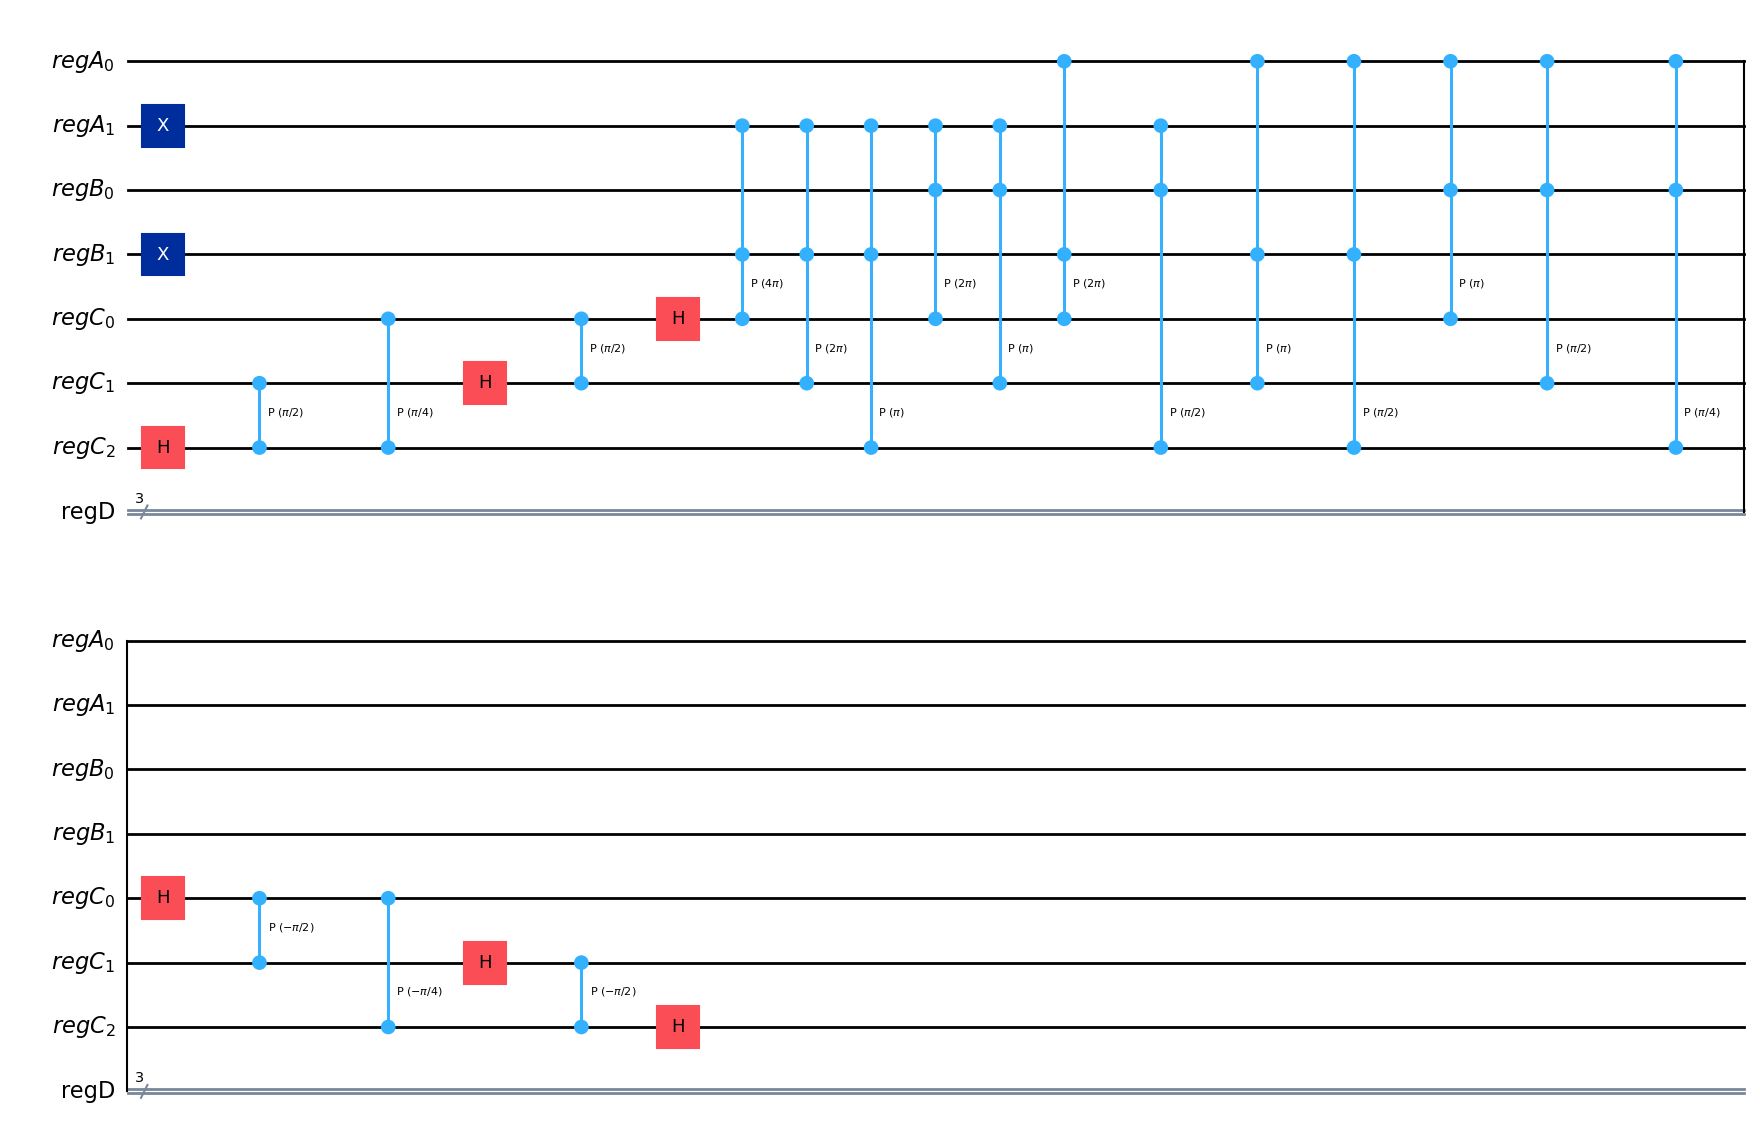

In [69]:
for target in range(maxInputLength + 1):
    qc.h(regC[target])
    for control in range(target+1, maxInputLength + 1):
        qc.cp(-math.pi/(2**(control-target)), regC[control], regC[target])
qc.draw("mpl", plot_barriers=False)

In [70]:
"""
#Decomposed to QFT 
qc.append(QFT(outputDigits, do_swaps=False).to_gate(), regC[:])

for j in range(1, maxInputLength + 1):
    for i in range(1, maxInputLength + 1):
        for k in range(1, outputDigits + 1):
            lam = (2 * math.pi) / (2 ** (i + j + k - 2 * maxInputLength))
            qc.append(
                PhaseGate(lam).control(2),
                [regA[maxInputLength - j], regB[maxInputLength - i], regC[k - 1]],
            )
qc.append(QFT(outputDigits, do_swaps=False).inverse().to_gate(), regC[:])
"""

# Prepared gate
#qc.append(RGQFTMultiplier(num_state_qubits=maxInputLength, num_result_qubits=outputDigits), qargs=regA[:] + regB[:] + regC[:])

'\n#Decomposed to QFT \nqc.append(QFT(outputDigits, do_swaps=False).to_gate(), regC[:])\n\nfor j in range(1, maxInputLength + 1):\n    for i in range(1, maxInputLength + 1):\n        for k in range(1, outputDigits + 1):\n            lam = (2 * math.pi) / (2 ** (i + j + k - 2 * maxInputLength))\n            qc.append(\n                PhaseGate(lam).control(2),\n                [regA[maxInputLength - j], regB[maxInputLength - i], regC[k - 1]],\n            )\nqc.append(QFT(outputDigits, do_swaps=False).inverse().to_gate(), regC[:])\n'

### 3.3  Measuring and running the simulation
Now that the circuit is fully constructed, we need to simulate it to obtain the results. We measure the `regB` in to `regC`, initialize a quantum simulator, compile our circuit for execution, and let it compute the result.

100


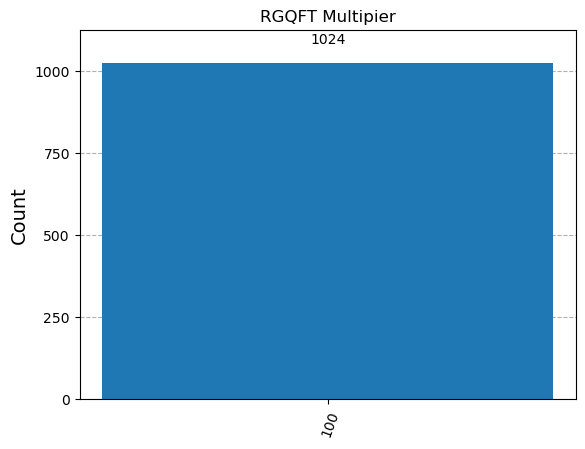

In [71]:
qc.measure(regC, regD)

simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

print(max(counts, key=counts.get))
plot_histogram(counts, title='RGQFT Multipier')